# COVID Global Clustering Scratchpad 

Do the same using Global data from John Hopkins University

https://github.com/CSSEGISandData/COVID-19   

https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv


## Clustering thoughts
- Take case + death counts
- Trending pattern (?  what is a good single value metric.. rolling 3 day or some momentum value?)
- Adding population data
- Population density ?
- Median age and age distributions

Attempt to cluster the countries ?


In [208]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import StringIO
import pandas as pd
import requests

dfc_graw = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
dfd_graw = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')

dfc_g = dfc_graw.drop(columns=['Lat','Long','Province/State']).groupby(['Country/Region']).sum().sort_values(dfc_graw.columns[-1], ascending=False)
dfc_g = dfc_g.transpose()  
dfc_g.index = pd.to_datetime(dfc_g.index)
display('cases',dfc_g.tail())
display('chg in cases',dfc_g.tail().diff(axis=0))

dfd_g = dfd_graw.drop(columns=['Lat','Long','Province/State']).groupby(['Country/Region']).sum().sort_values(dfd_graw.columns[-1], ascending=False)
dfd_g = dfd_g.transpose().tail(40)  # last 40 days ?
dfd_g.index = pd.to_datetime(dfd_g.index) 
display('deaths',dfd_g.tail())
display('chg in deaths',dfd_g.tail().diff(axis=0))

#display('details of', dfd_g['Sudan'].tail(15), dfc_g['Sudan'].tail(15))


'cases'

Country/Region,US,Spain,Italy,France,Germany,China,United Kingdom,Iran,Turkey,Belgium,...,Sierra Leone,Mauritania,Bhutan,Burundi,Sao Tome and Principe,Western Sahara,South Sudan,Timor-Leste,Papua New Guinea,Yemen
2020-04-07,396223,141942,135586,110065,107663,82718,55949,62589,34109,22194,...,6,6,5,3,4,4,2,1,2,0
2020-04-08,429052,148220,139422,113959,113296,82809,61474,64586,38226,23403,...,7,6,5,3,4,4,2,1,2,0
2020-04-09,461437,153222,143626,118781,118181,82883,65872,66220,42282,24983,...,7,7,5,3,4,4,3,1,2,0
2020-04-10,496535,158273,147577,125931,122171,82941,74605,68192,47029,26667,...,8,7,5,3,4,4,4,2,2,1
2020-04-11,526396,163027,152271,130727,124908,83014,79874,70029,52167,28018,...,8,7,5,5,4,4,4,2,2,1


'chg in cases'

Country/Region,US,Spain,Italy,France,Germany,China,United Kingdom,Iran,Turkey,Belgium,...,Sierra Leone,Mauritania,Bhutan,Burundi,Sao Tome and Principe,Western Sahara,South Sudan,Timor-Leste,Papua New Guinea,Yemen
2020-04-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-08,32829.0,6278.0,3836.0,3894.0,5633.0,91.0,5525.0,1997.0,4117.0,1209.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-04-09,32385.0,5002.0,4204.0,4822.0,4885.0,74.0,4398.0,1634.0,4056.0,1580.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2020-04-10,35098.0,5051.0,3951.0,7150.0,3990.0,58.0,8733.0,1972.0,4747.0,1684.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
2020-04-11,29861.0,4754.0,4694.0,4796.0,2737.0,73.0,5269.0,1837.0,5138.0,1351.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0


'deaths'

Country/Region,US,Italy,Spain,France,United Kingdom,Iran,Belgium,China,Germany,Netherlands,...,South Sudan,Papua New Guinea,Eritrea,Equatorial Guinea,Guinea,Guinea-Bissau,Dominica,Holy See,Laos,Fiji
2020-04-07,12722,17127,14045,10343,6171,3872,2035,3335,2016,2108,...,0,0,0,0,0,0,0,0,0,0
2020-04-08,14695,17669,14792,10887,7111,3993,2240,3337,2349,2255,...,0,0,0,0,0,0,0,0,0,0
2020-04-09,16478,18279,15447,12228,7993,4110,2523,3339,2607,2403,...,0,0,0,0,0,0,0,0,0,0
2020-04-10,18586,18849,16081,13215,8974,4232,3019,3340,2767,2520,...,0,0,0,0,0,0,0,0,0,0
2020-04-11,20463,19468,16606,13851,9892,4357,3346,3343,2736,2653,...,0,0,0,0,0,0,0,0,0,0


'chg in deaths'

Country/Region,US,Italy,Spain,France,United Kingdom,Iran,Belgium,China,Germany,Netherlands,...,South Sudan,Papua New Guinea,Eritrea,Equatorial Guinea,Guinea,Guinea-Bissau,Dominica,Holy See,Laos,Fiji
2020-04-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-08,1973.0,542.0,747.0,544.0,940.0,121.0,205.0,2.0,333.0,147.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-04-09,1783.0,610.0,655.0,1341.0,882.0,117.0,283.0,2.0,258.0,148.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-04-10,2108.0,570.0,634.0,987.0,981.0,122.0,496.0,1.0,160.0,117.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-04-11,1877.0,619.0,525.0,636.0,918.0,125.0,327.0,3.0,-31.0,133.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Global Population Comparisons

In [209]:
# GLobal Population 
# https://github.com/datasets/population/blob/master/data/population.csv

df_gpop = pd.read_csv('https://raw.githubusercontent.com/datasets/population/master/data/population.csv')
df_gpop_2016 = df_gpop[df_gpop['Year'] == 2016]
df_gpop_2016 = df_gpop_2016.rename(columns={'Country Name': 'Country/Region'})

display(df_gpop_2016.sort_values(by=['Value'], ascending=False).head(), dfc_g.tail(1).transpose().count())  #262 countries / n countries
df_gmerged = pd.merge(left=dfc_g.rename(columns={'US':'United States'}).tail(1).transpose(), right=df_gpop_2016, on='Country/Region').rename(columns={'Value':'Population'})
df_gmerged = df_gmerged.rename(columns={ df_gmerged.columns[1]: "Cases" })

display(df_gmerged.rename(columns={'US':'United States'}).sort_values(by=['Population'], ascending=False).head())

df_gmerged = pd.merge(left=dfd_g.rename(columns={'US':'United States'}).tail(1).transpose(), right=df_gmerged, on='Country/Region')
df_gmerged = df_gmerged.rename(columns={ df_gmerged.columns[1]: "Deaths" })
       
display(df_gmerged.sort_values(by=['Population'], ascending=False).head(), df_gmerged.tail(1).transpose().count())



,Country/Region,Country Code,Year,Value
2621,World,WLD,2016,7.442136e+09
968,IDA & IBRD total,IBT,2016,6.271593e+09
1481,Low & middle income,LMY,2016,6.252106e+09
1823,Middle income,MIC,2016,5.592833e+09
911,IBRD only,IBD,2016,4.697247e+09


2020-04-11    185
dtype: int64

,Country/Region,Cases,Country Code,Year,Population
5,China,83014,CHN,2016,1.378665e+09
18,India,8446,IND,2016,1.324171e+09
0,United States,526396,USA,2016,3.231275e+08
33,Indonesia,3842,IDN,2016,2.611155e+08
12,Brazil,20727,BRA,2016,2.076529e+08


,Country/Region,Deaths,Cases,Country Code,Year,Population
6,China,3343,83014,CHN,2016,1.378665e+09
20,India,288,8446,IND,2016,1.324171e+09
0,United States,20463,526396,USA,2016,3.231275e+08
16,Indonesia,327,3842,IDN,2016,2.611155e+08
9,Brazil,1124,20727,BRA,2016,2.076529e+08


156    6
dtype: int64

## Add Population Density from worldbank

In [269]:
# population density source
# http://api.worldbank.org/v2/en/indicator/EN.POP.DNST?downloadformat=csv   
from zipfile import ZipFile
import requests, zipfile, io
import urllib.request

def get_zip(url):
    urllib.request.urlretrieve(url, "GDP.zip")
    compressed_file = zipfile.ZipFile('GDP.zip')
    files = compressed_file.namelist()
    for f in files:
        if (f.find('API') == 0):
            csv_file = compressed_file.open(f)  # pattern match how?
            return pd.read_csv(csv_file, header=2)
    return None
    
popdensity = get_zip('http://api.worldbank.org/v2/en/indicator/EN.POP.DNST?downloadformat=csv')
popdensity = pd.concat([popdensity.iloc[:,0:2], popdensity['2018']], axis=1).rename(columns={'2018':'popdensity'})

df_gmerged2 = pd.merge(left=df_gmerged, right=popdensity, on='Country Code', how='left')
df_gmerged2['% of pop'] = (df_gmerged2['Cases'] / df_gmerged2['Population']).mul(100).round(2)

display(df_gmerged.shape, popdensity.shape, df_gmerged2.shape)
display(popdensity.head(), df_gmerged2.head().sort_values(by='Population', ascending=False))

(157, 6)

(264, 3)

(157, 9)

,Country Name,Country Code,popdensity
0,Aruba,ABW,588.027778
1,Afghanistan,AFG,56.937760
2,Angola,AGO,24.713052
3,Albania,ALB,104.612263
4,Andorra,AND,163.842553


,Country/Region,Deaths,Cases,Country Code,Year,Population,Country Name,popdensity,% of pop
0,United States,20463,526396,USA,2016,323127513.0,United States,35.766089,0.16
3,France,13851,130727,FRA,2016,66896109.0,France,122.338396,0.20
4,United Kingdom,9892,79874,GBR,2016,65637239.0,United Kingdom,274.827392,0.12
1,Italy,19468,152271,ITA,2016,60600590.0,Italy,205.450748,0.25
2,Spain,16606,163027,ESP,2016,46443959.0,Spain,93.529058,0.35


## Add demographics from worldbank

In [275]:
#  -- all available https://data.worldbank.org/indicator
# unemployment data http://api.worldbank.org/v2/en/indicator/SL.UEM.TOTL.ZS?downloadformat=csv
# hospital beds http://api.worldbank.org/v2/en/indicator/SH.MED.BEDS.ZS?downloadformat=csv
# air flights http://api.worldbank.org/v2/en/indicator/IS.AIR.DPRT?downloadformat=csv
# rail lines http://api.worldbank.org/v2/en/indicator/IS.RRS.TOTL.KM?downloadformat=csv
# employment F http://api.worldbank.org/v2/en/indicator/SL.TLF.CACT.FE.ZS?downloadformat=csv
# employment M http://api.worldbank.org/v2/en/indicator/SL.TLF.CACT.MA.ZS?downloadformat=csv
# unemployment http://api.worldbank.org/v2/en/indicator/SL.UEM.TOTL.ZS?downloadformat=csv
# urban pop http://api.worldbank.org/v2/en/indicator/SP.URB.TOTL.IN.ZS?downloadformat=csv
# pollution EN.ATM.PM25.MC.M3

def isfloat(value):
  try:
    float(value)
    return True
  except ValueError:
    return False

def add_metric(indicator, colname, dfm, year='2019', debug=True):
    dfnew = get_zip('http://api.worldbank.org/v2/en/indicator/'+indicator+'?downloadformat=csv')
    dfnew = dfnew.fillna(method='ffill', axis=1)[['Country Code', year]].rename(columns={year:colname})

    dfm = pd.merge(left=dfm , right=dfnew, on ='Country Code') 
    display(dfm[dfm['Country/Region'].isin(['Dominica','Japan'])].head()) if debug else None

    dfm[colname] = dfm[colname].astype(str).apply(lambda x: float(x) if isfloat(x) else 0.0).round(2)
    return dfm

df_gmerged3 = df_gmerged2.copy()
df_gmerged3['Population/M'] = df_gmerged3['Population'].div(10**6).round(2)
df_gmerged3['popdensity'] = df_gmerged3['popdensity'].round(2)

df_gmerged3 = add_metric('IS.AIR.DPRT', 'flights', df_gmerged3, year='2019', debug=True)
df_gmerged3 = add_metric('EN.ATM.PM25.MC.M3', 'pollution', df_gmerged3, year='2019', debug=True)
df_gmerged3 = add_metric('SL.UEM.TOTL.ZS', 'unemp%', df_gmerged3, year='2019', debug=True)
df_gmerged3 = add_metric('SH.MED.BEDS.ZS', 'hospbeds', df_gmerged3, year='2019', debug=True)
df_gmerged3 = add_metric('IS.RRS.TOTL.KM', 'railways', df_gmerged3, year='2019', debug=True)
df_gmerged3 = add_metric('SP.URB.TOTL.IN.ZS', 'urbanpop', df_gmerged3, year='2019', debug=True)

df_gmerged3 = df_gmerged3.sort_values(by='pollution', ascending=False)

display(df_gmerged3.shape, pd.concat([df_gmerged3.head(5), df_gmerged3[df_gmerged3['Country/Region'].isin(['Japan','United States','Dominica'])]], axis=0))


,Country/Region,Deaths,Cases,Country Code,Year,Population,Country Name,popdensity,% of pop,Population/M,flights
32,Japan,99,6005,JPN,2016,126994511.0,Japan,347.07,0.00,126.99,999594
155,Dominica,0,16,DMA,2016,73543.0,Dominica,95.50,0.02,0.07,IS.AIR.DPRT


,Country/Region,Deaths,Cases,Country Code,Year,Population,Country Name,popdensity,% of pop,Population/M,flights,pollution
32,Japan,99,6005,JPN,2016,126994511.0,Japan,347.07,0.00,126.99,999594.0,11.7048
155,Dominica,0,16,DMA,2016,73543.0,Dominica,95.50,0.02,0.07,0.0,19.4932


,Country/Region,Deaths,Cases,Country Code,Year,Population,Country Name,popdensity,% of pop,Population/M,flights,pollution,unemp%
32,Japan,99,6005,JPN,2016,126994511.0,Japan,347.07,0.00,126.99,999594.0,11.70,2.291
155,Dominica,0,16,DMA,2016,73543.0,Dominica,95.50,0.02,0.07,0.0,19.49,SL.UEM.TOTL.ZS


,Country/Region,Deaths,Cases,Country Code,Year,Population,Country Name,popdensity,% of pop,Population/M,flights,pollution,unemp%,hospbeds
32,Japan,99,6005,JPN,2016,126994511.0,Japan,347.07,0.00,126.99,999594.0,11.70,2.29,13.4
155,Dominica,0,16,DMA,2016,73543.0,Dominica,95.50,0.02,0.07,0.0,19.49,0.00,3.8


,Country/Region,Deaths,Cases,Country Code,Year,Population,Country Name,popdensity,% of pop,Population/M,flights,pollution,unemp%,hospbeds,railways
32,Japan,99,6005,JPN,2016,126994511.0,Japan,347.07,0.00,126.99,999594.0,11.70,2.29,13.4,16851.7
155,Dominica,0,16,DMA,2016,73543.0,Dominica,95.50,0.02,0.07,0.0,19.49,0.00,3.8,IS.RRS.TOTL.KM


,Country/Region,Deaths,Cases,Country Code,Year,Population,Country Name,popdensity,% of pop,Population/M,flights,pollution,unemp%,hospbeds,railways,urbanpop
32,Japan,99,6005,JPN,2016,126994511.0,Japan,347.07,0.00,126.99,999594.0,11.70,2.29,13.4,16851.7,91.616
155,Dominica,0,16,DMA,2016,73543.0,Dominica,95.50,0.02,0.07,0.0,19.49,0.00,3.8,0.0,70.483


(157, 16)

,Country/Region,Deaths,Cases,Country Code,Year,Population,Country Name,popdensity,% of pop,Population/M,flights,pollution,unemp%,hospbeds,railways,urbanpop
138,Nepal,0,9,NPL,2016,2.898277e+07,Nepal,195.94,0.00,28.98,71908.00,99.73,1.41,0.3,0.0,19.74
72,Niger,11,491,NER,2016,2.067299e+07,Niger,17.72,0.00,20.67,471.00,94.05,0.47,0.3,0.0,16.42
89,Qatar,6,2728,QAT,2016,2.569804e+06,Qatar,239.59,0.11,2.57,197811.00,91.19,0.09,1.2,0.0,99.14
20,India,288,8446,IND,2016,1.324171e+09,India,454.94,0.00,1324.17,1200111.36,90.87,5.36,0.7,68443.0,34.03
45,Saudi Arabia,52,4033,SAU,2016,3.227569e+07,Saudi Arabia,15.68,0.01,32.28,254063.75,87.95,5.93,2.7,2939.0,83.84
155,Dominica,0,16,DMA,2016,7.354300e+04,Dominica,95.50,0.02,0.07,0.00,19.49,0.00,3.8,0.0,70.48
32,Japan,99,6005,JPN,2016,1.269945e+08,Japan,347.07,0.00,126.99,999594.00,11.70,2.29,13.4,16851.7,91.62
0,United States,20463,526396,USA,2016,3.231275e+08,United States,35.77,0.16,323.13,9879630.00,7.41,3.68,2.9,150462.3,82.26


In [215]:
# read from JSON directly
# EN.ATM.PM25.MC.M3 - polution
# able to aggrecate and get last value, not sure what source= is    ?source=2&format=json&mrnev=1&per_page=500
#   http://api.worldbank.org/v2/country/all/indicator/EN.ATM.PM25.MC.M3;SH.MED.BEDS.ZS;IS.AIR.DPRT;IS.RRS.TOTL.KM;SP.URB.TOTL.IN.ZS;SP.POP.TOTL;SL.UEM.TOTL.ZS?source=2&format=json&mrnev=1&per_page=5000
jurl = 'http://api.worldbank.org/v2/country/all/indicator/EN.ATM.PM25.MC.M3;SH.MED.BEDS.ZS;IS.AIR.DPRT;IS.RRS.TOTL.KM;SP.URB.TOTL.IN.ZS;SP.POP.TOTL;SL.UEM.TOTL.ZS?source=2&format=json&mrnev=1&per_page=5000'
    
r = requests.get(jurl)
display(r.text)
    
pd.read_json(r.text)



'[{"page":1,"pages":1,"per_page":5000,"total":1353,"sourceid":null,"lastupdated":"2020-04-09"},[{"indicator":{"id":"SH.MED.BEDS.ZS","value":"Hospital beds (per 1,000 people)"},"country":{"id":"1A","value":"Arab World"},"countryiso3code":"ARB","date":"2014","value":1.62452358185493,"obs_status":"","decimal":1},{"indicator":{"id":"IS.AIR.DPRT","value":"Air transport, registered carrier departures worldwide"},"country":{"id":"1A","value":"Arab World"},"countryiso3code":"ARB","date":"2018","value":1493348.76870414,"obs_status":"","decimal":0},{"indicator":{"id":"SP.URB.TOTL.IN.ZS","value":"Urban population (% of total population)"},"country":{"id":"1A","value":"Arab World"},"countryiso3code":"ARB","date":"2018","value":58.9254185931391,"obs_status":"","decimal":0},{"indicator":{"id":"SP.POP.TOTL","value":"Population, total"},"country":{"id":"1A","value":"Arab World"},"countryiso3code":"ARB","date":"2018","value":419790588,"obs_status":"","decimal":0},{"indicator":{"id":"SL.UEM.TOTL.ZS","va

AttributeError: 'list' object has no attribute 'keys'

# Pop Density vs Case counts

C:\Users\dougc\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: `item` has been deprecated and will be removed in a future version
  # Remove the CWD from sys.path while we load stuff.


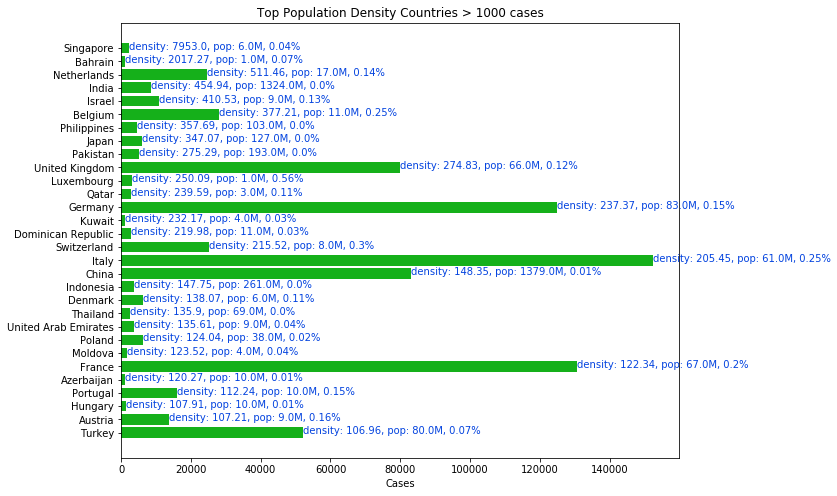

In [212]:
max_ctys = 30
fig,ax1 = plt.subplots(figsize=(10, 8)) 

df_gmerged_h = df_gmerged2[df_gmerged2['Cases'] > 1000].sort_values(by=['popdensity'],ascending=False).head(max_ctys)

ax1.set_xlabel('Cases')  
ax1.set_xscale('linear')
ax1.barh(df_gmerged_h['Country/Region'], df_gmerged_h['Cases'], color='xkcd:green')
for n,i in enumerate(ax1.patches):
    ax1.text(i.get_width()+.02, i.get_y()+.5,'density: '+str(df_gmerged_h['popdensity'].iloc[n:n+1].round(2).item()) + ', pop: '+str(df_gmerged_h['Population'].iloc[n:n+1].div(1000000).round(0).item()) +'M, '+str(df_gmerged_h['% of pop'].iloc[n:n+1].round(2).item())  +'%', color='xkcd:blue')

# ax2 = ax1.twiny()
# ax2.set_xscale('linear')
# ax2.set(xlim=[0, 10])   # get max min +/- buffer
# ax2.set_xlabel('Population density', color='xkcd:red')  
# ax2.spines['top'].set_color('red')
# ax2.tick_params(axis='x', colors='red')
# ax2.barh(df_gmerged_h['Country/Region'], df_gmerged_h['popdensity'], color='xkcd:red')
# for n,i in enumerate(ax2.patches):
#     ax2.text(i.get_width()+.02, i.get_y()+.5,str(df_gmerged_h['popdensity'].iloc[n:n+1].item()), color='xkcd:red')

plt.title('Top Population Density Countries > 1000 cases')
plt.gca().invert_yaxis()
plt.show()